In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from scipy import stats

import seaborn as sns
import scienceplots
plt.style.use(['science', 'no-latex'])

In [3]:
def get_z_score(confidence_level):
    tail_prob = (1 - confidence_level) / 2
    return stats.norm.ppf(1 - tail_prob)

# Plotting configurations

In [4]:
data_choice = "1"

In [5]:
with open('PlotterConfig.json', 'r') as file:
    plot_config = json.load(file)
    
ONE_FIGURE       = plot_config["OneFigure"]                  # Will everything lay on a single figure
LAST             = plot_config["Last"]                       # How many days to use for mean and dev.

LOG_X_SCALE      = plot_config["LogXaxis" + data_choice]     # Will use log scale on x axis
COMMON_X_LABEL   = plot_config["SupXLabel" + data_choice]    # Common x axis label
SKIP_SHARES      = plot_config["SkipShares" + data_choice]   # Skip shares in the plots
WSPACE           = plot_config["WSpace" + data_choice]       # Width space between subplots

LABEL_FONT_SIZE  = plot_config["LabelFont" + data_choice]    # Font size for axis labels
LEGEND_FONT_SIZE = plot_config["LegendFont" + data_choice]   # Font size for legends
TEXT_FONT_SIZE   = plot_config["TextFont" + data_choice]     # Font size for behavior indicating text
CLIP_BARS        = plot_config["ClipBars" + data_choice]     # Clip error bars by min-max values
COLORS           = plot_config["Colors" + data_choice]       # Colors for the plots
HATCHES          = plot_config["Hatches" + data_choice]      # Hatches for the error bars
MARKERS          = plot_config["Markers" + data_choice]      # Markers for the plots
EXP_DIR          = plot_config["name" + data_choice]         # Experiment directory name

dirpath = "data/" + EXP_DIR + "/"                           # Directory to the data

# Experiment configurations

In [6]:
with open(dirpath + 'EData.json', 'r') as file:
    experiment_data = json.load(file)
with open(dirpath + 'paramsData.json', 'r') as file:
    experiment_params = json.load(file)

In [7]:
EFILENAME   = experiment_data["name"]
cav_shares  = experiment_data["Yval"]                           # Shares
#behaviors   = experiment_data["Xval"]                           # Behaviors
behaviors   = ["Selfish", "Social", "Altruistic", "Malicious", "Disruptive"]
fleet_intro = experiment_params["defaultFleetIntroduction"]     # Fleet introduction day
num_days    = experiment_params["dayRange"]                     # Number of days in an experiment

In [8]:
if SKIP_SHARES > 0: cav_shares = cav_shares[SKIP_SHARES:-SKIP_SHARES]
title_days = f"{num_days - LAST} - {num_days}"

labels_counts       = ["HDV count on A", "HDV count on B", "CAV count on A", "CAV count on B"]
labels_legend       = ["HDV on A", "HDV on B", "CAV on A", "CAV on B"]
labels_tt           = ["Travel time on A", "Travel time on B", "Mean HDV travel time", "Mean CAV travel time"]
labels_legend_tt    = ["A TT", "B TT", "Mean HDV TT", "Mean CAV TT"]

In [9]:
print(f"Plotting CAV shares: {cav_shares}")

Plotting CAV shares: [0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.98, 0.99, 0.995]


# Experiment results

In [10]:
dfdict = dict()
for beh_idx in range(len(behaviors)):
    for shr_idx in range(len(cav_shares)):
        filepath = f"{dirpath}{EFILENAME}_{behaviors[beh_idx]}_{cav_shares[shr_idx]}.csv"
        dfdict[beh_idx, shr_idx] = pd.read_csv(filepath)
    
dfdict[0, 0].head()

,Unnamed: 0,Day,Travel time on A,Travel time on B,Mean HDV travel time,Mean HDV Perceived travel time,Mean CAV travel time,HDV count on A,HDV count on B,CAV count on A,CAV count on B
0,0,0.0,9.96008,20.906344,15.455104,15.290494,0.0,498.0,502.0,0.0,0.0
1,1,1.0,18.91112,15.645844,18.369084,16.536317,0.0,834.0,166.0,0.0,0.0
2,2,2.0,17.54528,16.014000,17.226774,15.084924,0.0,792.0,208.0,0.0,0.0
3,3,3.0,14.94050,17.039648,15.559749,12.945496,0.0,705.0,295.0,0.0,0.0
4,4,4.0,14.94050,17.039648,15.559749,12.896038,0.0,705.0,295.0,0.0,0.0


### Calculate means, deviations, percentiles

In [19]:
dfs_means, dfs_means_hdv_before, dfs_std, dfs_first_perc, dfs_last_perc, dfs_first_perc_tt, dfs_last_perc_tt \
    = dict(), dict(), dict(), dict(), dict(), dict(), dict()

for beh_idx in range(len(behaviors)):
    for shr_idx in range(len(cav_shares)):
        dfs_means[beh_idx, shr_idx] = np.mean(dfdict[beh_idx, shr_idx].tail(LAST), axis=0) 
        dfs_means[beh_idx, shr_idx]['behavior']=behaviors[beh_idx]
        dfs_means[beh_idx, shr_idx]['share']=cav_shares[shr_idx]
        dfs_means_hdv_before[beh_idx, shr_idx] = np.mean(dfdict[beh_idx, shr_idx][fleet_intro - LAST:fleet_intro], axis=0)
        dfs_means_hdv_before[beh_idx, shr_idx]['behavior']=behaviors[beh_idx]
        dfs_means_hdv_before[beh_idx, shr_idx]['share']=cav_shares[shr_idx]
        dfs_std[beh_idx, shr_idx] = np.std(dfdict[beh_idx, shr_idx].tail(LAST), axis=0)
        dfs_std[beh_idx, shr_idx]['behavior']=behaviors[beh_idx]
        dfs_std[beh_idx, shr_idx]['share']=cav_shares[shr_idx]
        for l in range(len(labels_counts)):            
            dfs_first_perc[beh_idx, shr_idx, l] = np.percentile(dfdict[beh_idx, shr_idx][labels_counts[l]].tail(LAST), 0, axis=0)
            dfs_last_perc[beh_idx, shr_idx, l] = np.percentile(dfdict[beh_idx, shr_idx][labels_counts[l]].tail(LAST), 100, axis=0)
        for l in range(len(labels_tt)):            
            dfs_first_perc_tt[beh_idx, shr_idx, l] = np.percentile(dfdict[beh_idx, shr_idx][labels_tt[l]].tail(LAST), 0, axis=0)
            dfs_last_perc_tt[beh_idx, shr_idx, l] = np.percentile(dfdict[beh_idx, shr_idx][labels_tt[l]].tail(LAST), 100, axis=0)

In [20]:
df_means = pd.concat([dfs_means[beh_idx, shr_idx].to_frame().T for beh_idx in range(len(behaviors)) for shr_idx in range(len(cav_shares))])
df_means_hdv_before = pd.concat([dfs_means_hdv_before[beh_idx, shr_idx].to_frame().T for beh_idx in range(len(behaviors)) for shr_idx in range(len(cav_shares))])
df_std = pd.concat([dfs_std[beh_idx, shr_idx].to_frame().T for beh_idx in range(len(behaviors)) for shr_idx in range(len(cav_shares))])

df_means.to_csv('df_means.csv')
df_means_hdv_before.to_csv('df_means_hdv_before.csv')
df_std.to_csv('df_std.csv')

In [21]:
print(f"Peek at the flat data: {df_means.shape}")
df_means.sample(10)

Peek at the flat data: (125, 13)


,Unnamed: 0,Day,Travel time on A,Travel time on B,Mean HDV travel time,Mean HDV Perceived travel time,Mean CAV travel time,HDV count on A,HDV count on B,CAV count on A,CAV count on B,behavior,share
0,349.5,349.5,13.898494,17.600266,15.158495,12.260525,13.898494,646.99,333.01,20.0,0.0,Malicious,0.02
0,349.5,349.5,12.206523,18.746394,13.841565,11.756143,18.746394,600.24,199.76,0.0,200.0,Altruistic,0.2
0,349.5,349.5,12.12818,18.806461,13.785443,11.484769,17.23239,526.29,173.71,70.71,229.29,Social,0.3
0,349.5,349.5,13.373537,17.919769,14.781994,12.007458,15.174531,345.17,154.83,301.88,198.12,Selfish,0.5
0,349.5,349.5,13.411608,17.897354,14.931414,12.322713,17.897354,648.48,331.52,0.0,20.0,Social,0.02
0,349.5,349.5,14.053173,17.510593,15.245832,12.351935,14.053173,622.77,327.23,50.0,0.0,Selfish,0.05
0,349.5,349.5,14.562232,17.23246,15.53338,12.444172,14.562232,541.43,308.57,150.0,0.0,Malicious,0.15
0,349.5,349.5,14.017035,17.530119,15.202287,12.552674,15.079299,497.14,252.86,174.31,75.69,Selfish,0.25
0,349.5,349.5,18.370377,15.906067,17.129907,14.287946,18.631548,171.43,178.57,643.5,6.5,Disruptive,0.65
0,349.5,349.5,12.539635,18.492697,14.483499,11.768877,14.845311,13.49,6.51,600.49,379.51,Disruptive,0.98


In [22]:
palette = sns.color_palette('deep')
palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [23]:
print(f"Peek at the mean data: {len(dfs_means)} results ({len(behaviors)}x{len(cav_shares)})")
dfs_means[0, 0]

Peek at the mean data: 125 results (5x25)


Unnamed: 0                            349.5
Day                                   349.5
Travel time on A                  13.645116
Travel time on B                  17.751933
Mean HDV travel time               15.06143
Mean HDV Perceived travel time    12.139387
Mean CAV travel time              13.645116
HDV count on A                       652.42
HDV count on B                       342.58
CAV count on A                          5.0
CAV count on B                          0.0
behavior                            Selfish
share                                 0.005
dtype: object

---

In [24]:
# To-Do: Fix sizing ine OneFigure mode
if ONE_FIGURE:
    onefig = plt.figure()
    subfigs = onefig.subfigures(nrows=4, ncols=1, hspace=0, wspace=WSPACE)

# Plot 1

In [25]:
NAMES_PLOT_1 = ['travel time increase against optimal','travel time equity']
df_means['mean_time']= ((df_means['HDV count on A']+df_means['CAV count on A'])*df_means['Travel time on A']+(df_means['HDV count on B']+df_means['CAV count on B'])*df_means['Travel time on B'])/1000
#df_means['eq']= ((((df_means['HDV count on A']+df_means['CAV count on A'])*(df_means['Travel time on A']-df_means['mean_time'])**2+(df_means['HDV count on B']+df_means['CAV count on B'])*(df_means['Travel time on B']-df_means['mean_time'])**2)/1000))**(0.5)
df_means[NAMES_PLOT_1[0]]= df_means.mean_time/df_means.mean_time.min()
df_means[NAMES_PLOT_1[1]]= (df_means[['Travel time on A','Travel time on B']].max(axis = 1)-df_means[['Travel time on A','Travel time on B']].min(axis = 1))/df_means[['Travel time on A','Travel time on B']].min(axis = 1)

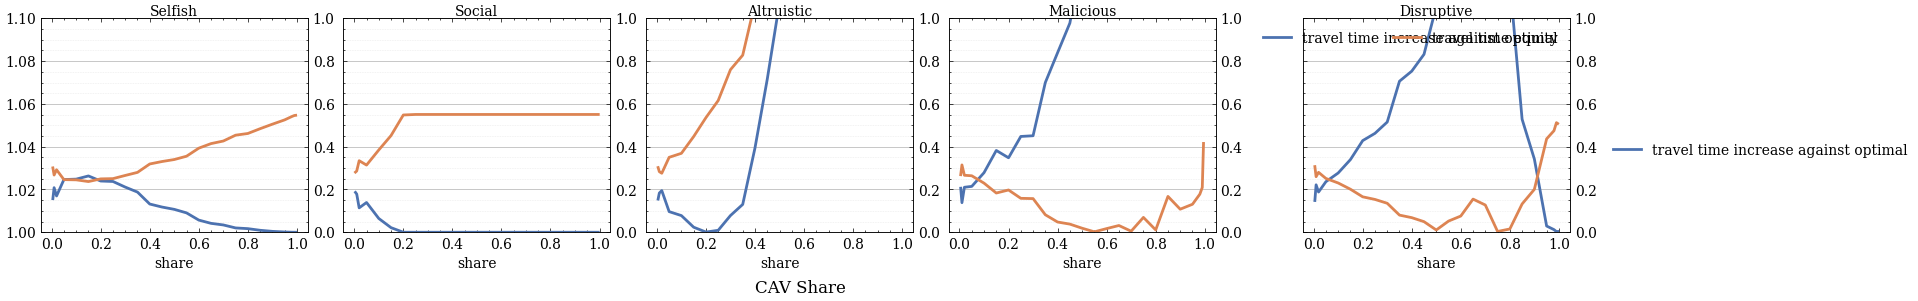

In [77]:
if ONE_FIGURE: fig = subfigs[0]
else: fig = plt.figure(figsize=(16, 3), layout='constrained')

gs = fig.add_gridspec(1, len(behaviors), hspace=0, wspace=WSPACE)
axs = gs.subplots(sharex=True, sharey=True)
ax_twins = [ _.twinx() for _ in axs]
[ _.set_ylim(0,1) for _ in ax_twins]

if LOG_X_SCALE: plt.xscale("log")
axs[0].set_ylim(1,1.1)


z_score = get_z_score(0.4)

fontweight = 'normal'


for beh_idx, behavior in enumerate(behaviors):

    

    ax = axs[beh_idx]
    ax_twin = ax_twins[beh_idx]
    
    
    mean_A_TT = [dfs_means[beh_idx, shr_idx]["Travel time on A"] for shr_idx in range(len(cav_shares))]
    std_A_TT = [dfs_std[beh_idx, shr_idx]["Travel time on A"] for shr_idx in range(len(cav_shares))]
    
    mean_B_TT = [dfs_means[beh_idx, shr_idx]["Travel time on B"] for shr_idx in range(len(cav_shares))]
    std_B_TT = [dfs_std[beh_idx, shr_idx]["Travel time on B"] for shr_idx in range(len(cav_shares))]
    
    mean_HDV_TT = [dfs_means[beh_idx, shr_idx]["Mean HDV travel time"] for shr_idx in range(len(cav_shares))]
    std_HDV_TT = [dfs_std[beh_idx, shr_idx]["Mean HDV travel time"] for shr_idx in range(len(cav_shares))]
    
    mean_CAV_TT = [dfs_means[beh_idx, shr_idx]["Mean CAV travel time"] for shr_idx in range(len(cav_shares))]
    std_CAV_TT = [dfs_std[beh_idx, shr_idx]["Mean CAV travel time"] for shr_idx in range(len(cav_shares))]
    
    meanAll = np.vstack((mean_A_TT, mean_B_TT, mean_HDV_TT, mean_CAV_TT))
    stdAll = np.vstack((std_A_TT, std_B_TT, std_HDV_TT, std_CAV_TT))

    sns.lineplot(data = df_means[df_means.behavior==behavior],x = 'share', y = NAMES_PLOT_1[0],  ax = ax, color = palette[0], label = NAMES_PLOT_1[0] if behavior == "Disruptive" else None, lw = 2)
    sns.lineplot(data = df_means[df_means.behavior==behavior],x = 'share', y = NAMES_PLOT_1[1],  ax = ax_twin, color =  palette[1], label = NAMES_PLOT_1[1] if behavior == "Disruptive" else None, lw = 2)
    
    # for idx, (mean_data, std_data) in enumerate(zip(meanAll, stdAll)):
    #     ax.plot(cav_shares, mean_data, label=labels_legend_tt[idx], color=COLORS[idx], marker=MARKERS)
    #     lower_bound = mean_data - z_score * std_data
    #     upper_bound = mean_data + z_score * std_data
    #     ax.fill_between(cav_shares, lower_bound, upper_bound, color=COLORS[idx], alpha=0.3, hatch=HATCHES[idx])
            
    ax.set_title(behavior, transform=ax.transAxes, fontsize=TEXT_FONT_SIZE, fontweight=fontweight, va='top') #, loc="left")
    ax.minorticks_on()
    
    
    ax.get_yaxis().label.set_visible(False)
    ax_twin.get_yaxis().label.set_visible(False)
    ax.grid(axis='y', which='minor', color='#EEEEEE', linestyle=(0,(1,1)), linewidth=0.6)
    ax.grid(axis='y')

fig.supxlabel(COMMON_X_LABEL, fontsize=LABEL_FONT_SIZE, fontweight=fontweight)
#fig.supylabel("Time (minutes)", fontsize=LABEL_FONT_SIZE, fontweight=fontweight)
handles1, labels1= ax.get_legend_handles_labels()
fig.legend(handles1, labels1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=LEGEND_FONT_SIZE, prop={'weight': fontweight})

if not ONE_FIGURE:  plt.show()

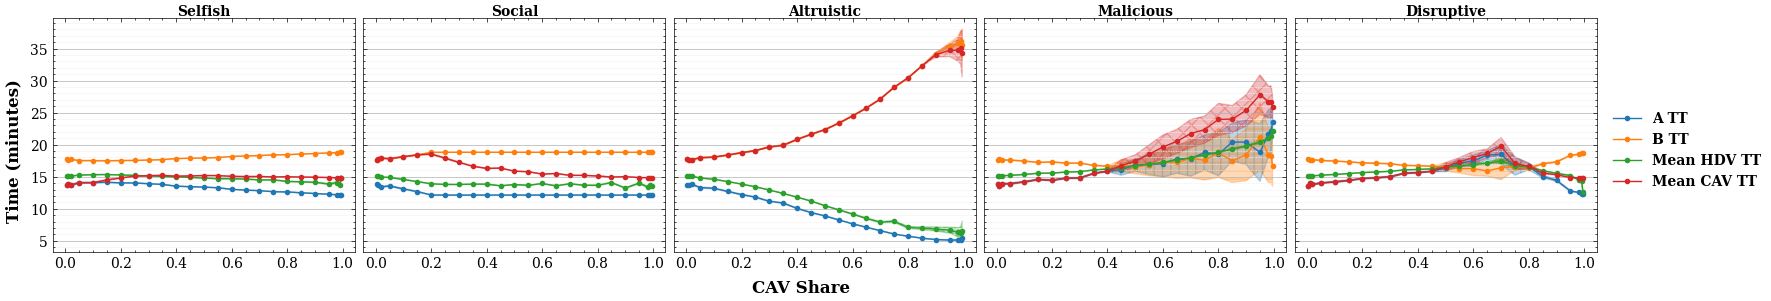

In [ ]:
if ONE_FIGURE: fig = subfigs[0]
else: fig = plt.figure(figsize=(16, 3), layout='constrained')

gs = fig.add_gridspec(1, len(behaviors), hspace=0, wspace=WSPACE)
axs = gs.subplots(sharex=True, sharey=True)
if LOG_X_SCALE: plt.xscale("log")

z_score = get_z_score(0.4)

for beh_idx, behavior in enumerate(behaviors):
    ax = axs[beh_idx]
    
    mean_A_TT = [dfs_means[beh_idx, shr_idx]["Travel time on A"] for shr_idx in range(len(cav_shares))]
    std_A_TT = [dfs_std[beh_idx, shr_idx]["Travel time on A"] for shr_idx in range(len(cav_shares))]
    
    mean_B_TT = [dfs_means[beh_idx, shr_idx]["Travel time on B"] for shr_idx in range(len(cav_shares))]
    std_B_TT = [dfs_std[beh_idx, shr_idx]["Travel time on B"] for shr_idx in range(len(cav_shares))]
    
    mean_HDV_TT = [dfs_means[beh_idx, shr_idx]["Mean HDV travel time"] for shr_idx in range(len(cav_shares))]
    std_HDV_TT = [dfs_std[beh_idx, shr_idx]["Mean HDV travel time"] for shr_idx in range(len(cav_shares))]
    
    mean_CAV_TT = [dfs_means[beh_idx, shr_idx]["Mean CAV travel time"] for shr_idx in range(len(cav_shares))]
    std_CAV_TT = [dfs_std[beh_idx, shr_idx]["Mean CAV travel time"] for shr_idx in range(len(cav_shares))]
    
    meanAll = np.vstack((mean_A_TT, mean_B_TT, mean_HDV_TT, mean_CAV_TT))
    stdAll = np.vstack((std_A_TT, std_B_TT, std_HDV_TT, std_CAV_TT))
    
    for idx, (mean_data, std_data) in enumerate(zip(meanAll, stdAll)):
        ax.plot(cav_shares, mean_data, label=labels_legend_tt[idx], color=COLORS[idx], marker=MARKERS)
        lower_bound = mean_data - z_score * std_data
        upper_bound = mean_data + z_score * std_data
        ax.fill_between(cav_shares, lower_bound, upper_bound, color=COLORS[idx], alpha=0.3, hatch=HATCHES[idx])
            
    ax.set_title(behavior, transform=ax.transAxes, fontsize=TEXT_FONT_SIZE, fontweight='bold', va='top') #, loc="left")
    ax.minorticks_on()
    ax.grid(axis='y', which='minor', color='#EEEEEE', linestyle=(0,(1,1)), linewidth=0.6)
    ax.grid(axis='y')

fig.supxlabel(COMMON_X_LABEL, fontsize=LABEL_FONT_SIZE, fontweight='bold')
fig.supylabel("Time (minutes)", fontsize=LABEL_FONT_SIZE, fontweight='bold')
handles1, labels1= ax.get_legend_handles_labels()
fig.legend(handles1, labels1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=LEGEND_FONT_SIZE, prop={'weight': 'bold'})

if not ONE_FIGURE:  plt.show()

# Plot 2

'.'

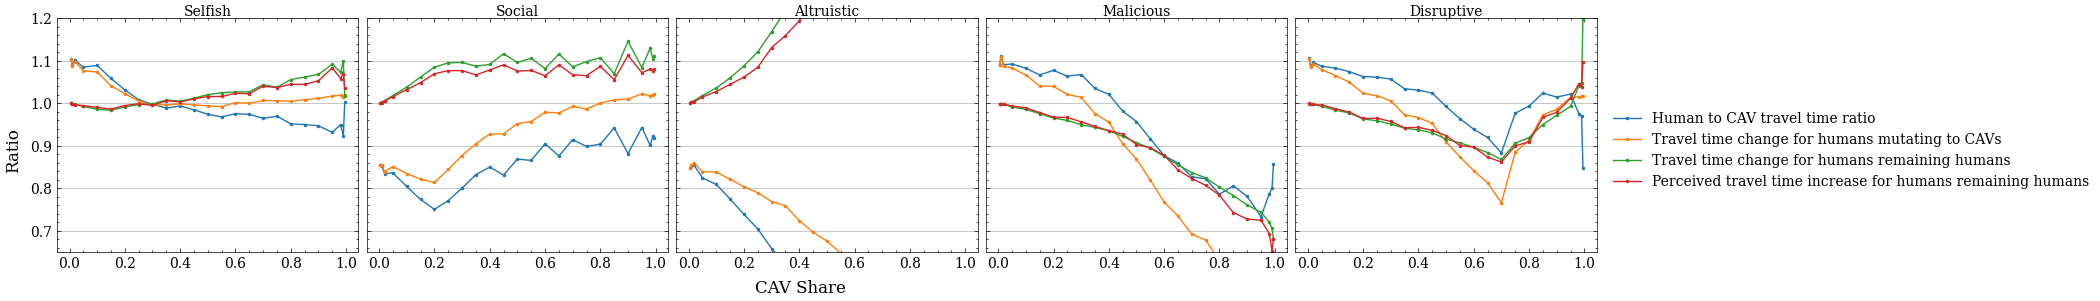

In [135]:
if ONE_FIGURE: fig = subfigs[1]
else: fig = plt.figure(figsize=(16, 3), layout='constrained')

gs = fig.add_gridspec(1, len(behaviors), hspace=0, wspace=WSPACE)
axs = gs.subplots(sharex=True, sharey=True)
if LOG_X_SCALE: plt.xscale("log")

z_score = get_z_score(0.7)
fontweight = 'normal'

LABELS = ['Human to CAV travel time ratio', 'Travel time change for humans mutating to CAVs', 'Travel time change for humans remaining humans', 'Perceived travel time increase for humans remaining humans']

for beh_idx, behavior in enumerate(behaviors):
    ax = axs[beh_idx]
    ax.set_ylim(bottom = 0.65, top = 1.2)
    
    mean_HDV_TT =  [dfs_means[beh_idx, shr_idx]["Mean HDV travel time"] for shr_idx in range(len(cav_shares))]
    mean_HDV_TT_before =  [dfs_means_hdv_before[beh_idx, shr_idx]["Mean HDV travel time"] for shr_idx in range(len(cav_shares))]
    mean_CAV_TT =  [dfs_means[beh_idx, shr_idx]["Mean CAV travel time"] for shr_idx in range(len(cav_shares))]
    mean_HDV_perception =  [dfs_means[beh_idx, shr_idx]["Mean HDV Perceived travel time"] for shr_idx in range(len(cav_shares))]
    mean_HDV_perception_before =  [dfs_means_hdv_before[beh_idx, shr_idx]["Mean HDV Perceived travel time"] for shr_idx in range(len(cav_shares))]
    
    delta_a = [mean_HDV_TT[shr_idx]/mean_CAV_TT[shr_idx] for shr_idx in range(len(cav_shares)) if (mean_CAV_TT[shr_idx]>0)]
    delta_b = [mean_HDV_TT_before[shr_idx]/mean_CAV_TT[shr_idx] for shr_idx in range(len(cav_shares)) if (mean_CAV_TT[shr_idx]>0)]
    delta_c = [mean_HDV_TT_before[shr_idx]/mean_HDV_TT[shr_idx] for shr_idx in range(len(cav_shares)) if (mean_HDV_TT[shr_idx]>0)]
    delta_d = [mean_HDV_perception_before[shr_idx]/mean_HDV_perception[shr_idx] for shr_idx in range(len(cav_shares)) if (mean_HDV_TT[shr_idx]>0)]

    ax.plot(cav_shares, delta_a, label = LABELS[0], color = COLORS[0], marker = MARKERS, lw = 1, alpha = 1, markersize = 3)
    ax.plot(cav_shares, delta_b, label = LABELS[1], color = COLORS[1], marker = MARKERS, lw = 1, alpha = 1, markersize = 3)
    ax.plot(cav_shares, delta_c, label = LABELS[2], color = COLORS[2], marker = MARKERS, lw = 1, alpha = 1, markersize = 3)
    ax.plot(cav_shares, delta_d, label = LABELS[3], color = COLORS[3], marker = MARKERS, lw = 1, alpha = 1, markersize = 3)
    
    ax.set_title(behavior, transform=ax.transAxes, fontsize=TEXT_FONT_SIZE, fontweight=fontweight, va='top') #, loc="left")
    ax.minorticks_on()
    #ax.grid(axis='y', which='minor', color='#EEEEEE', linestyle=(0,(1,1)), linewidth=0.6)
    ax.grid(axis='y')
    
fig.supxlabel(COMMON_X_LABEL, fontsize=LABEL_FONT_SIZE, fontweight=fontweight)
fig.supylabel("Ratio", fontsize=LABEL_FONT_SIZE, fontweight=fontweight)
handles2, labels2= ax.get_legend_handles_labels()
fig.legend(handles2, labels2, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=LEGEND_FONT_SIZE, prop={'weight': fontweight})

if not ONE_FIGURE:  plt.show()

# Plot 3


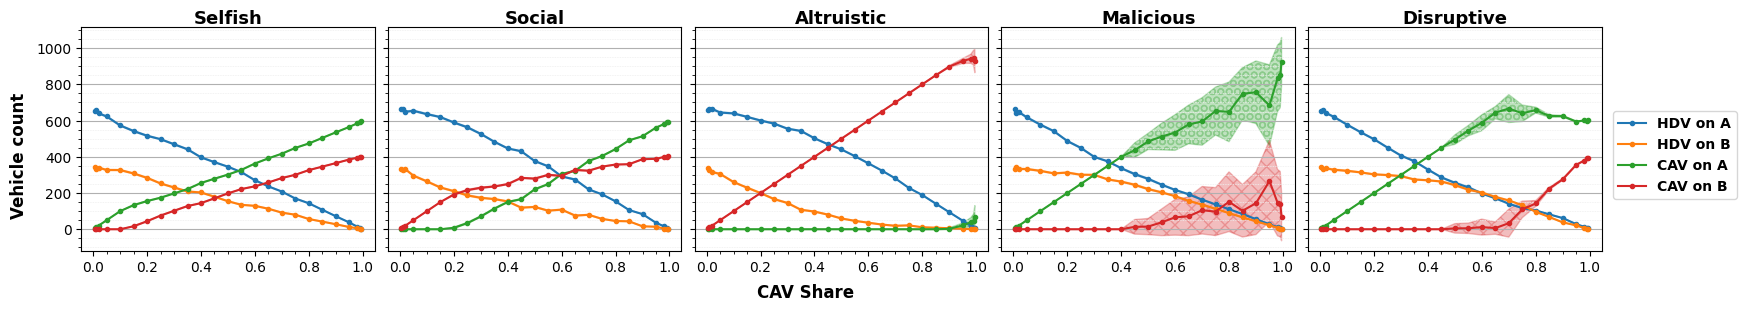

In [178]:
if ONE_FIGURE: fig = subfigs[2]
else: fig = plt.figure(figsize=(16, 3), layout='constrained')

gs = fig.add_gridspec(1, len(behaviors), hspace=0, wspace=WSPACE)
axs = gs.subplots(sharex=True, sharey=True)
if(LOG_X_SCALE): plt.xscale("log")

z_score = get_z_score(0.4)

for beh_idx, behavior in enumerate(behaviors):
    ax = axs[beh_idx]
    
    means_HDV_A = [dfs_means[beh_idx, shr_idx]["HDV count on A"] for shr_idx in range(len(cav_shares))]
    std_HDV_A = [dfs_std[beh_idx, shr_idx]["HDV count on A"] for shr_idx in range(len(cav_shares))]
    
    means_HDV_B = [dfs_means[beh_idx, shr_idx]["HDV count on B"] for shr_idx in range(len(cav_shares))]
    std_HDV_B = [dfs_std[beh_idx, shr_idx]["HDV count on B"] for shr_idx in range(len(cav_shares))]
    
    means_CAV_A = [dfs_means[beh_idx, shr_idx]["CAV count on A"] for shr_idx in range(len(cav_shares))]
    std_CAV_A = [dfs_std[beh_idx, shr_idx]["CAV count on A"] for shr_idx in range(len(cav_shares))]
    
    means_CAV_B = [dfs_means[beh_idx, shr_idx]["CAV count on B"] for shr_idx in range(len(cav_shares))]
    std_CAV_B = [dfs_std[beh_idx, shr_idx]["CAV count on B"] for shr_idx in range(len(cav_shares))]

    meanAll = np.vstack((means_HDV_A, means_HDV_B, means_CAV_A, means_CAV_B))
    stdAll = np.vstack((std_HDV_A, std_HDV_B, std_CAV_A, std_CAV_B))
    
    for idx, (mean_data, std_data) in enumerate(zip(meanAll, stdAll)):
        lower_bound = mean_data - z_score * std_data
        upper_bound = mean_data + z_score * std_data
        color, hatch = COLORS[idx], HATCHES[idx]
        ax.plot(cav_shares, mean_data, label=labels_legend[idx], color=color, marker=MARKERS)
        ax.fill_between(cav_shares, lower_bound, upper_bound, color=color, alpha=0.3, hatch=hatch)

    ax.set_title(behavior, transform=ax.transAxes, fontsize=13, fontweight='bold', va='top') #, loc="left")ax.minorticks_on()
    ax.minorticks_on()
    ax.grid(axis='y', which='minor', color='#EEEEEE', linestyle=(0,(1,1)), linewidth=0.6)
    ax.grid(axis='y')

fig.supxlabel(COMMON_X_LABEL, fontsize=LABEL_FONT_SIZE, fontweight='bold')
fig.supylabel("Vehicle count", fontsize=LABEL_FONT_SIZE, fontweight='bold')

handles3, labels3 = ax.get_legend_handles_labels()
fig.legend(handles3, labels3, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=LEGEND_FONT_SIZE, prop={'weight': 'bold'})

if not ONE_FIGURE:  plt.show()

# Plot 4

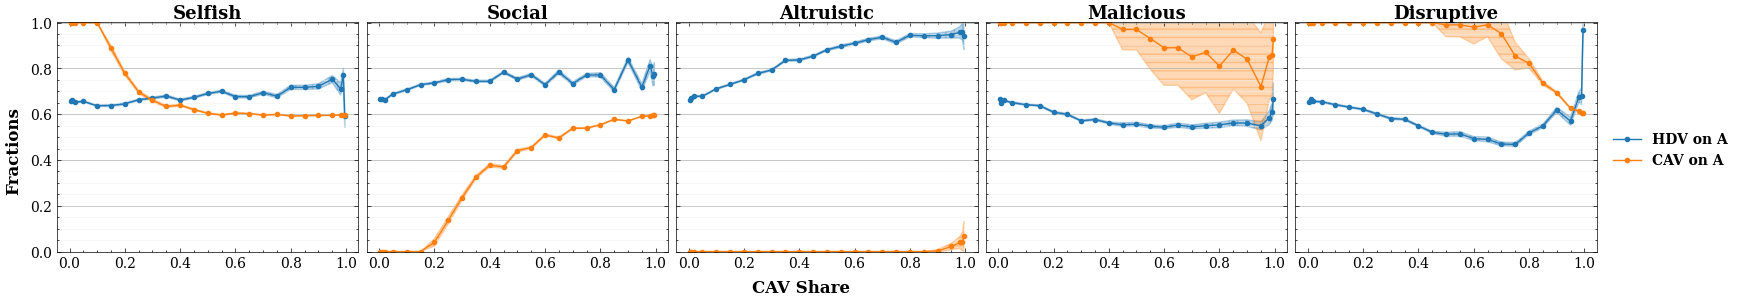

In [73]:
if ONE_FIGURE: fig = subfigs[3]
else: fig = plt.figure(figsize=(16, 3), layout='constrained')

gs = fig.add_gridspec(1, len(behaviors), hspace=0, wspace=WSPACE)
axs = gs.subplots(sharex=True, sharey=True)
axs[0].set_ylim(-0.001,1.001)
if(LOG_X_SCALE): plt.xscale("log")

z_score = get_z_score(0.4)

for beh_idx, behavior in enumerate(behaviors):
    ax = axs[beh_idx]
    
    fractions_HDV_A = [dfs_means[beh_idx, j]["HDV count on A"] / (dfs_means[beh_idx, j]["HDV count on A"] + dfs_means[beh_idx, j]["HDV count on B"]) for j in range(len(cav_shares))]
    #fractions_HDV_B = [dfs_means[beh_idx, j]["HDV count on B"] / (dfs_means[beh_idx, j]["HDV count on A"] + dfs_means[beh_idx, j]["HDV count on B"]) for j in range(len(cav_shares))]
    fractions_CAV_A = [dfs_means[beh_idx, j]["CAV count on A"] / (dfs_means[beh_idx, j]["CAV count on A"] + dfs_means[beh_idx, j]["CAV count on B"]) for j in range(len(cav_shares))]
    #fractions_CAV_B = [dfs_means[beh_idx, j]["CAV count on B"] / (dfs_means[beh_idx, j]["CAV count on A"] + dfs_means[beh_idx, j]["CAV count on B"]) for j in range(len(cav_shares))]
    
    
    #get_std = lambda unscaled_std, count_a, count_b: (unscaled_std**2 / (count_a + count_b))**0.5 # Std dev -> variance -> scale by total count -> std dev
    get_std = lambda unscaled_std, count_a, count_b: unscaled_std / (count_a + count_b) # Scale std dev by the total count
    std_error_HDV_A = [get_std(dfs_std[beh_idx, j]["HDV count on A"], dfs_means[beh_idx, j]["HDV count on A"], dfs_means[beh_idx, j]["HDV count on B"]) for j in range(len(cav_shares))]
    #std_error_HDV_B = [get_std(dfs_std[beh_idx, j]["HDV count on B"], dfs_means[beh_idx, j]["HDV count on A"], dfs_means[beh_idx, j]["HDV count on B"]) for j in range(len(cav_shares))]
    std_error_CAV_A = [get_std(dfs_std[beh_idx, j]["CAV count on A"], dfs_means[beh_idx, j]["CAV count on A"], dfs_means[beh_idx, j]["CAV count on B"]) for j in range(len(cav_shares))]
    #std_error_CAV_B = [get_std(dfs_std[beh_idx, j]["CAV count on B"], dfs_means[beh_idx, j]["CAV count on A"], dfs_means[beh_idx, j]["CAV count on B"]) for j in range(len(cav_shares))]
    
    
    fractions_data = np.vstack((fractions_HDV_A, fractions_CAV_A, ))
    std_error_data = np.vstack((std_error_HDV_A,  std_error_CAV_A))
    
    for idx, (fractions, std_error) in enumerate(zip(fractions_data, std_error_data)):
        lower_bound = fractions - z_score * std_error
        upper_bound = fractions + z_score * std_error
        
        color, hatch = COLORS[idx], HATCHES[idx]
        ax.plot(cav_shares, fractions, label=labels_legend[idx*2], color=color, marker=MARKERS)
        ax.fill_between(cav_shares, lower_bound, upper_bound, color=color, alpha=0.3, hatch=hatch)

    ax.set_title(behavior, transform=ax.transAxes, fontsize=13, fontweight='bold', va='top') #, loc="left")ax.minorticks_on()
    ax.minorticks_on()
    ax.grid(axis = 'y', which='minor', color='#EEEEEE', linestyle=(0,(1,1)), linewidth=0.6)
    ax.grid(axis = 'y')

fig.supxlabel(COMMON_X_LABEL, fontsize=LABEL_FONT_SIZE, fontweight='bold')
fig.supylabel("Fractions", fontsize=LABEL_FONT_SIZE, fontweight='bold')

handles4, labels4 = ax.get_legend_handles_labels()
fig.legend(handles4, labels4, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=LEGEND_FONT_SIZE, prop={'weight': 'bold'})

if not ONE_FIGURE:  plt.show()

In [180]:
if ONE_FIGURE:
    onefig.savefig(f"exp1_all.png")